In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
train_path = "C:/Users/yuvraj/OneDrive/Desktop/jupyter notebook/Human Action Recognition/train"
test_path = "C:/Users/yuvraj/OneDrive/Desktop/jupyter notebook/Human Action Recognition/test"
train_csv_path = "C:/Users/yuvraj/OneDrive/Desktop/jupyter notebook/Human Action Recognition/Training_set.csv"
test_csv_path = "C:/Users/yuvraj/OneDrive/Desktop/jupyter notebook/Human Action Recognition/Testing_set.csv"


In [5]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

print(train_df.columns)


Index(['filename', 'label'], dtype='object')


In [6]:
categories = train_df['label'].astype('category').cat.categories

In [7]:
pio.renderers.default = "notebook"

fig = px.histogram(train_df, x='label', title='Distribution of Classes in Training Set')
fig.show()

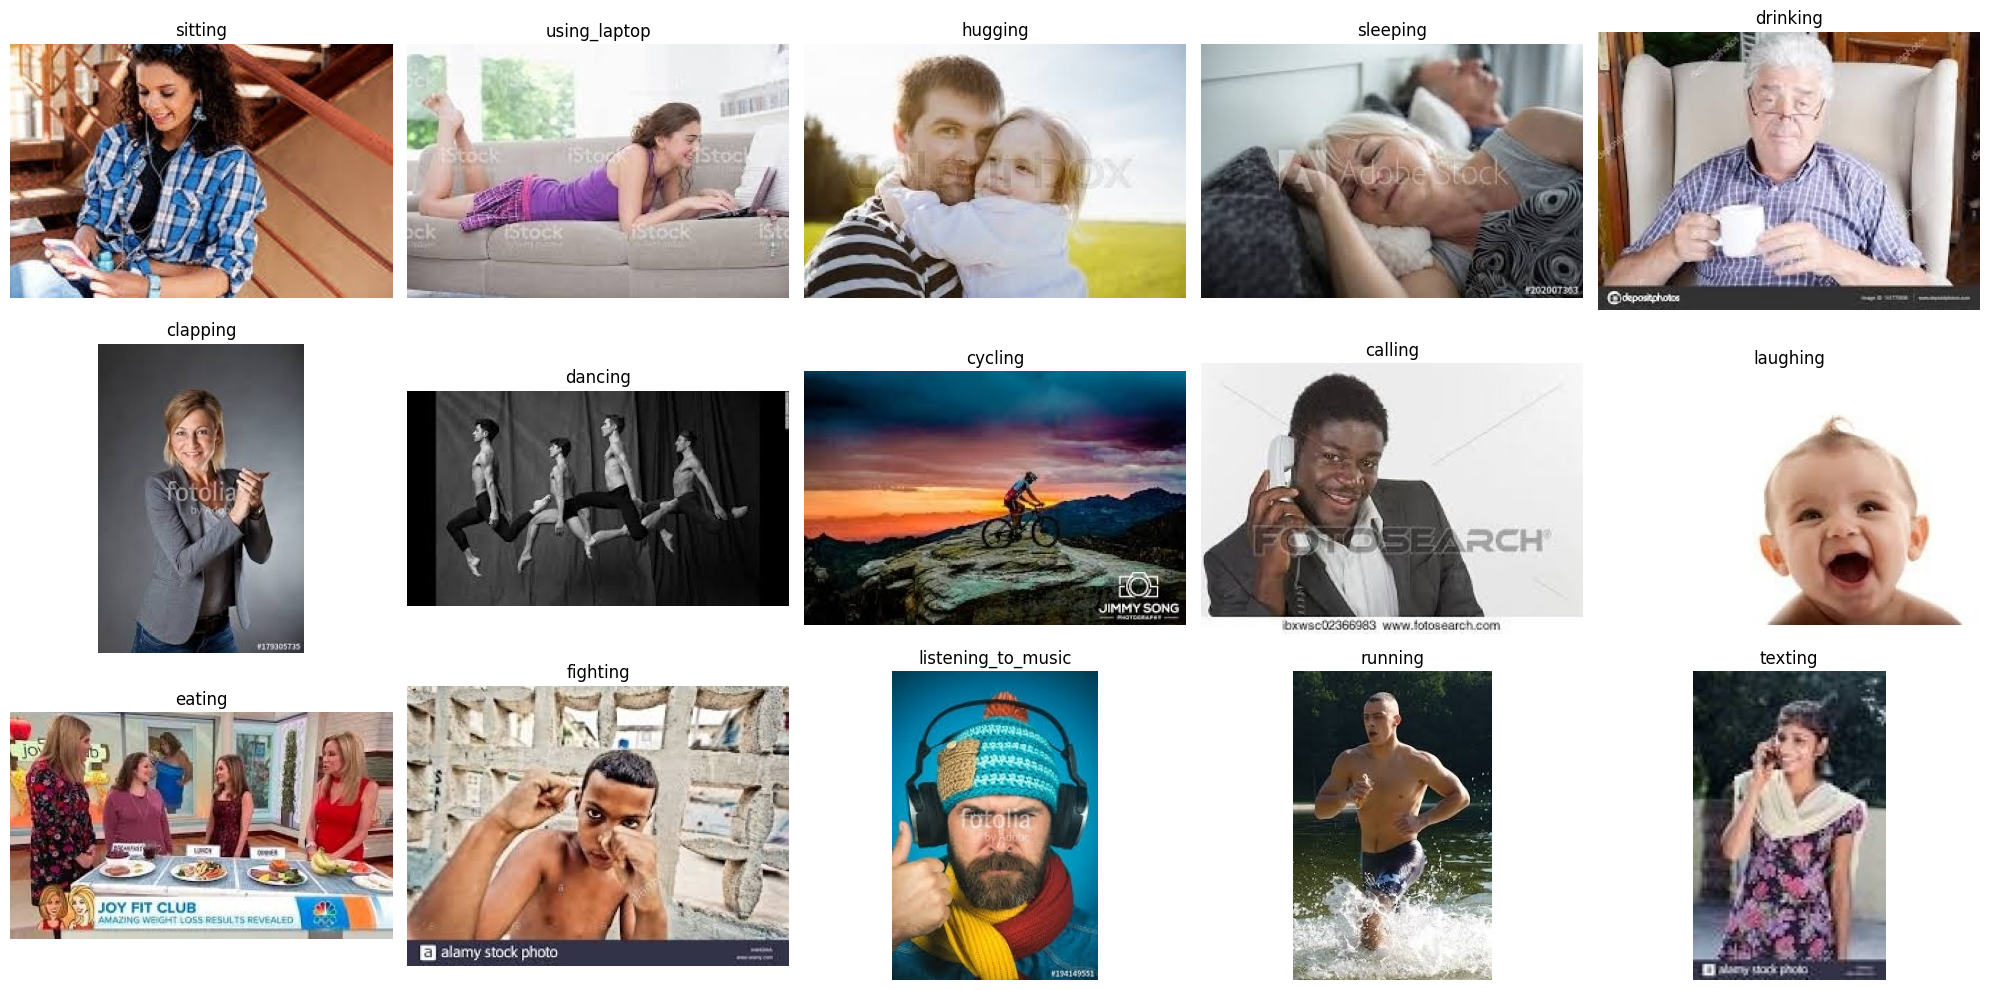

In [8]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()
for idx, class_name in enumerate(train_df['label'].unique()):
    class_images = train_df[train_df['label'] == class_name]['filename'].values
    img = plt.imread(os.path.join(train_path, class_images[0]))
    axes[idx].imshow(img)
    axes[idx].set_title(class_name)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

In [9]:
train_df['label'] = train_df['label'].astype('category')
train_df['label'] = train_df['label'].cat.codes
train_df['filepath'] = train_df['filename'].apply(lambda x: os.path.join(train_path, x))

In [10]:
train_set, val_set = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

In [11]:
def load_image(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0
    return image, label

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_set['filepath'].values, train_set['label'].values))
train_dataset = train_dataset.map(load_image).batch(32).shuffle(buffer_size=len(train_set))

val_dataset = tf.data.Dataset.from_tensor_slices((val_set['filepath'].values, val_set['label'].values))
val_dataset = val_dataset.map(load_image).batch(32)

In [12]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\yuvraj\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [13]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=30)

Epoch 1/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 212s 593ms/step - accuracy: 0.0891 - loss: 2.6929 - val_accuracy: 0.1706 - val_loss: 2.5246
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 215s 617ms/step - accuracy: 0.1819 - loss: 2.4942 - val_accuracy: 0.2452 - val_loss: 2.3356
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 201s 578ms/step - accuracy: 0.2380 - loss: 2.3384 - val_accuracy: 0.2488 - val_loss: 2.3575
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 229s 678ms/step - accuracy: 0.2833 - loss: 2.1946 - val_accuracy: 0.3087 - val_loss: 2.1732
Epoch 5/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 220s 631ms/step - accuracy: 0.3552 - loss: 1.9850 - val_accuracy: 0.3194 - val_loss: 2.1494
Epoch 6/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 234s 643ms/step - accuracy: 0.4104 - loss: 1.7931 - val_accuracy: 0.3115 - val_loss: 2.1718
Epoch 7/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 212s 595ms/step - accuracy: 0.4677 - loss: 1.6035 - val_accuracy: 0.3187 - val_loss: 2.2414
Epoch 8/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 209s 614ms/step - accuracy: 0.5207 -

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(history.history['accuracy'])), y=history.history['accuracy'], mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=np.arange(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'))
fig.update_layout(title='Model Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy')
fig.show()

# Plot Training and Validation Loss
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(history.history['loss'])), y=history.history['loss'], mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=np.arange(len(history.history['val_loss'])), y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(title='Model Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

In [15]:
val_predictions = np.argmax(model.predict(val_dataset), axis=-1)
val_labels = np.concatenate([y.numpy() for x, y in val_dataset], axis=0)

# Classification Report
print(classification_report(val_labels, val_predictions, target_names=categories))

79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step
                    precision    recall  f1-score   support

           calling       0.21      0.15      0.18       168
          clapping       0.26      0.30      0.28       168
           cycling       0.55      0.61      0.58       168
           dancing       0.34      0.39      0.36       168
          drinking       0.24      0.23      0.24       168
            eating       0.43      0.35      0.39       168
          fighting       0.36      0.45      0.40       168
           hugging       0.26      0.29      0.27       168
          laughing       0.32      0.39      0.35       168
listening_to_music       0.28      0.14      0.19       168
           running       0.36      0.36      0.36       168
           sitting       0.24      0.25      0.24       168
          sleeping       0.42      0.42      0.42       168
           texting       0.16      0.16      0.16       168
      using_laptop       0.37      0.37      0.37       1

In [16]:
conf_matrix = confusion_matrix(val_labels, val_predictions)
fig = px.imshow(conf_matrix, text_auto=True, title='Confusion Matrix')
fig.show()

In [17]:
model.save('C:/Users/yuvraj/OneDrive/Desktop/jupyter notebook/har_model.h5')

In [18]:
model.save('C:/Users/yuvraj/OneDrive/Desktop/jupyter notebook/har_model.keras')

In [19]:
test_df['filepath'] = test_df['filename'].apply(lambda x: os.path.join(test_path, x))

test_dataset = tf.data.Dataset.from_tensor_slices(test_df['filepath'].values)
test_dataset = test_dataset.map(lambda x: (tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(x), channels=3), [128, 128]) / 255.0)).batch(32)

In [20]:
test_predictions = np.argmax(model.predict(test_dataset), axis=-1)
test_df['label'] = test_predictions

169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 228ms/step


In [21]:
label_map = {i: label for i, label in enumerate(categories)}
test_df['label'] = test_df['label'].map(label_map)

In [23]:
submission = test_df[['filename', 'label']]
submission.to_csv('C:/Users/yuvraj/OneDrive/Desktop/jupyter notebook/submissionnnn.csv', index=False)

Categories: Index(['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating',
       'fighting', 'hugging', 'laughing', 'listening_to_music', 'running',
       'sitting', 'sleeping', 'texting', 'using_laptop'],
      dtype='object')


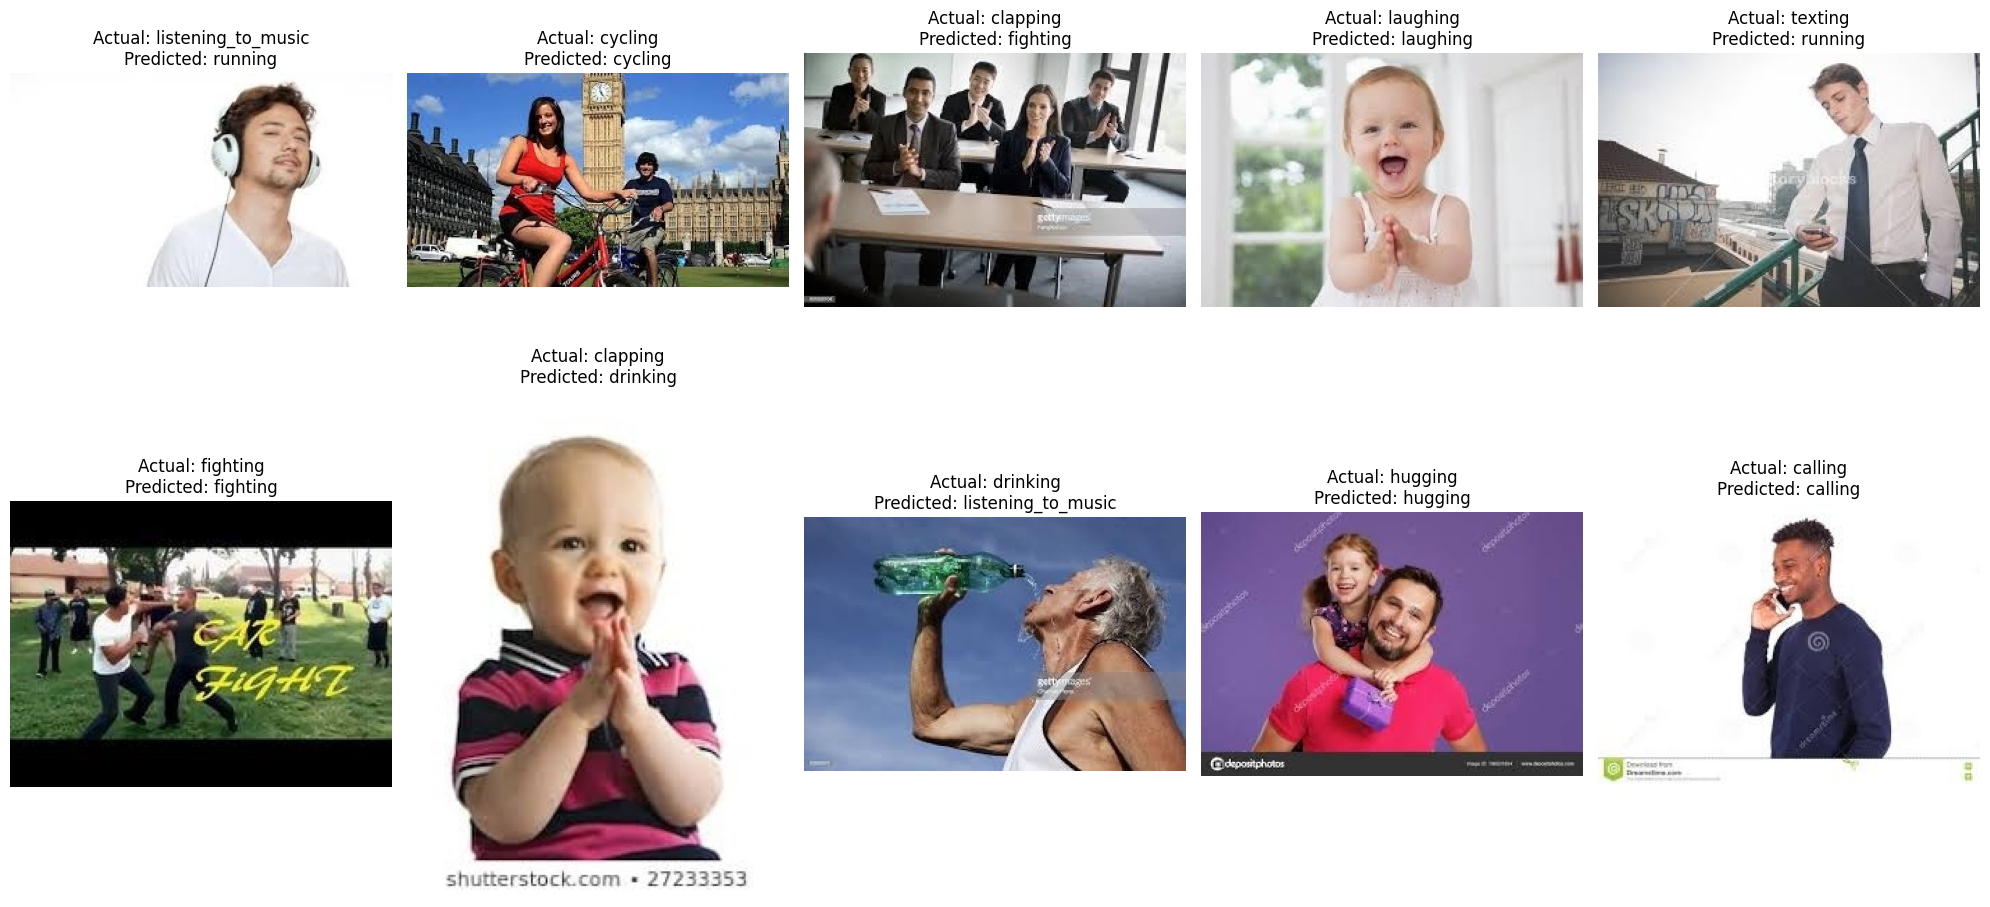

In [24]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()
print("Categories:", categories)
sampled_val_set = val_set.sample(10, random_state=42)
for i, (index, row) in enumerate(sampled_val_set.iterrows()):
    img = plt.imread(row['filepath'])
    actual_label = categories[row['label']]
    predicted_label = categories[val_predictions[val_set.index.get_loc(index)]]
    axes[i].imshow(img)
    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()
